Epochs对象是一种将连续数据表示为时间段集合的方法，

其存储在数组(n_events,n_channels,n_times)
其创建方式可以查看：

MNE中数据结构Epoch及其创建方法

本例介绍Epoch对象的常见用法

In [3]:
# a. 创建epoch对象
#     1）读取fif文件，创建raw对象
#     2）创建events对象
#     3）创建epoch对象

import mne
import os.path as op
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# 第一步：创建raw对象

data_path = mne.datasets.sample.data_path()

# 加载包含事件events的听觉数据集
raw = mne.io.read_raw_fif(op.join(data_path,
                                  'MEG', 
                                  'sample',
                                  'sample_audvis_raw.fif'
                                 )
                         )

Opening raw data file C:\Users\Administrator\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0


In [13]:
# 第二步：创建events对象

# 构造事件数组

events = mne.find_events(raw,stim_channel='STI 014')
# 显示事件数
print('Number of events:',len(events))

# 显示所有唯一的事件编号(第3列)

print('Unique event codes:',np.unique(events[:,2]))

"""
使用描述性标签指定感兴趣的事件代码。
给不同的events一个描述性名称。
"""
event_id={'Auditory/Left':1,
            'Auditory/Right':2}

# 这里可以用上述提取的事件创建mne.Epochs对象，
# 但该方式构造的epoch是无法使用，
# 因为数据还未读入到内存中，
# 可以通过get_data来获取 也可以使用preload=True.

320 events found
Event IDs: [ 1  2  3  4  5 32]
Number of events: 320
Unique event codes: [ 1  2  3  4  5 32]


In [14]:
# 第三步：创建epoch对象

# 把原始数据(raw)切分成若干个epoch(时间片段)的集合，    
# 以每个提前标准好的event为参照，取tmin到tmax这一段时间作为一个epoch来进行数据处理。    

# 取每个event的前0.1秒和后1秒共1.1秒的时间长度作为一个epoch,  
# 为后续同类型的event的epochs叠加(average)分析做准备。  


epochs = mne.Epochs(raw,
                    events,
                    event_id,
                    tmin=-0.1,
                    tmax=1,
                    baseline=(None, 0),
                    preload=True)
print(epochs)


# 发现145个匹配事件
# 应用基线校正(模式:平均值)
# 不设置元数据
# 创建一个SSP操作符(子空间维数=3)
# 激活3个proiection item
# 加载145个事件和662个原始时间点的数据…
# 糟糕的时代过去了
# <Epochs | 145个事件(都很好)，-0.0998976-1.00064秒，基线[无，01，~279.0 MB，数据加载，'听觉/左':72听觉/右:732

145 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Loading data for 145 events and 662 original time points ...
0 bad epochs dropped
<Epochs  |   145 events (all good), -0.0998976 - 1.00064 sec, baseline [None, 0], ~279.0 MB, data loaded,
 'Auditory/Left': 72
 'Auditory/Right': 73>


In [17]:
# b.查看epoch对象
# epochs对象类似于mne.io.Raw对象，也具有info属性和event属性。
# 可以通过下面两种方式来查看epoch内的event相关信息


print(epochs.events[:3])
print(epochs.event_id)[[27977,0,2][28771,0,1][29652,0,2]]

{'Auditory/Left': 1, 'Auditory/Right': 2}

# 也可以通过使用python的列表切片方式访问epoch对象内的events,
# 也可以通过events的描述性名称直接访问

print(epochs[1:5])
print(epochs['Auditory/Right'])

# 说明:'/'符号用来划分标签（tag），每个被'/'划分开的单词都可以作为检索的字符串，
# 也可以直接搜索epochs['Right']也能得到结果


print(epochs['Right'])
print(epochs['Right', 'Left'])

[[27977     0     2]
 [28771     0     1]
 [29652     0     2]]
{'Auditory/Left': 1, 'Auditory/Right': 2}


TypeError: list indices must be integers or slices, not tuple

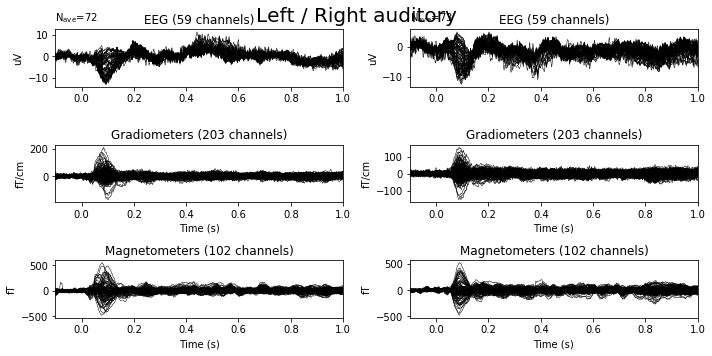

In [19]:
# c.epoch平均叠加

# 通过调用mne.Epochs.average()方法可返回Evoked对象，average()方法可以通过参数指定需要的信道。


ev_left = epochs['Auditory/Left'].average()
ev_right = epochs['Auditory/Right'].average()

f, axs = plt.subplots(3, 2, figsize=(10, 5))

_ = f.suptitle('Left / Right auditory',fontsize=20)
_ = ev_left.plot(axes=axs[:, 0],show=False,time_unit='s')
_ = ev_right.plot(axes=axs[:, 1],show=False,time_unit='s')

plt.tight_layout()



# 左上角图，该图展示了原始数据中左听觉(事件标记'Auditory/Left')的epochs，
# 同时对所提取的所有的EEG通道进行平均值叠加处理。
# 在实际过程中也可以指定通道进行叠加(通过pick方法提取通道并进行average处理)